In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from typing import Tuple
import pandas as pd
import os
import numpy as np
from scipy.ndimage import gaussian_filter

In [2]:
class PhysicsLSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int):
        super(PhysicsLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc_kalman = nn.Linear(hidden_size, 1)  # Predict angle
        self.mass_network = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, 1),
            nn.ReLU()
        )
        #self.Shouler_angle = nn.linear(hidden_size,1)
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_step = lstm_out[:, -1, :]  
        kalman_angle = self.fc_kalman(last_step)
        mass = self.mass_network(last_step)
        #shoulder_angle = self.Shoulder_angle(last_step)
        return kalman_angle, mass

In [3]:
class ModifiedPiLSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int,
                 I1: float = 0, I2: float = 0, m1: float = 0, m2: float = 0.6,
                 l1: float = 0, l2: float = 0.25, g: float = 9.81):
        super(ModifiedPiLSTM, self).__init__()
        self.model = PhysicsLSTM(input_size, hidden_size)
        self.I1 = I1
        self.I2 = I2
        self.m1 = m1
        self.m2 = m2
        self.l1 = l1
        self.l2 = l2
        self.g = g
    def calculate_state_variables(self, theta, dt = 0.02):
        theta_dot = torch.gradient(theta.squeeze(), spacing=(dt,))[0]
        theta_ddot = torch.gradient(theta_dot, spacing=(dt,))[0]
        
        return theta.unsqueeze(1), theta_dot.unsqueeze(1), theta_ddot.unsqueeze(1)
    
    def forward(self, x: torch.Tensor):
        return self.model(x)
    
    def calc_torque(self, angular, mass, true_mass):
        """Calculate physics-based torque using only angle"""
        angle = torch.deg2rad(180+angular)
        theta_E, theta_dot_E, theta_ddot_E = self.calculate_state_variables(angle)
        I1 = torch.tensor(self.I1, dtype=torch.float32)
        I2 = torch.tensor(self.I2, dtype=torch.float32)
        m1 = torch.tensor(self.m1, dtype=torch.float32)
        m2 = torch.tensor(self.m2, dtype=torch.float32)
        l1 = torch.tensor(self.l1, dtype=torch.float32)
        l2 = torch.tensor(self.l2, dtype=torch.float32)
        g = torch.tensor(self.g, dtype=torch.float32)
        mean_mass = torch.mean(mass,dim=0)
        # Set shoulder angle and its derivatives to zero
        theta_S = torch.zeros_like(theta_E)
        theta_dot_S = torch.zeros_like(theta_E)
        theta_ddot_S = torch.zeros_like(theta_E)
    
        # Calculate C matrix components for elbow torque
        C21 = (m2 * l1 * l2 / 2 + mean_mass * l1 * l2)  # Coefficient for shoulder acceleration
        C22 = (I2 + m2 * (l2**2) / 4 + mean_mass * l2**2)  # Coefficient for elbow acceleration
        C23 = (m2 * l1 * l2 / 2 + mean_mass * l1 * l2)  # Coefficient for shoulder velocity squared term
        C24 = ((m2 * l2 / 2 + mean_mass * l2) * g)  # Coefficient for gravitational term
        
        torque_E = (C21 * torch.cos(theta_S - theta_E) * theta_ddot_S - 
                C23 * torch.sin(theta_S - theta_E) * (theta_dot_S ** 2) + 
                C22 * theta_ddot_E +
                C24 * torch.sin(theta_E))
    
        return torque_E

    def physics_loss(self, pred_angle: torch.Tensor, pred_mass: torch.Tensor, 
                    true_mass: torch.Tensor) -> torch.Tensor:
        """Calculate physics-based loss using simplified pendulum dynamics"""
        pred_torque = self.calc_torque(pred_angle, pred_mass, true_mass)
        expected_torque = self.calc_torque(pred_angle, true_mass, true_mass)
        return torch.mean((pred_torque - expected_torque) ** 2)
    
    def combined_loss(self, pred_kalman: torch.Tensor, true_kalman: torch.Tensor,
                     pred_mass: torch.Tensor, true_mass: torch.Tensor,
                     physics_weight: float = 0.001,
                     mass_weight: float = 500) -> torch.Tensor:
        """Combined loss: data loss (for angle and mass) + physics-informed loss"""
        criterion_data = nn.MSELoss()
        
        # Data-driven loss for both angle and mass
        loss_angle = criterion_data(pred_kalman, true_kalman)
        loss_mass = criterion_data(pred_mass, true_mass)
        
        # Physics-informed loss
        loss_physics = self.physics_loss(pred_kalman, pred_mass, true_mass)
        
        return loss_angle + mass_weight * loss_mass + physics_weight * loss_physics

In [4]:
def train_model(model: nn.Module, train_loader: DataLoader, 
                num_epochs: int, learning_rate: float = 0.001) -> list:
    """Train the physics-informed LSTM model"""
    device = next(model.parameters()).device  # Ensure compatibility with model's device
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=30, gamma=0.5)
    train_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # Move data to GPU
            
            optimizer.zero_grad()
            
            # Forward pass
            pred_kalman, pred_mass = model(batch_x)
            
            # Prepare targets
            true_kalman = batch_y[:, 0].unsqueeze(1)
            true_mass = batch_y[:, 1].unsqueeze(1)
            
            # Calculate loss
            loss = model.combined_loss(pred_kalman, true_kalman, 
                                       pred_mass, true_mass)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        scheduler.step()
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        if epoch % 1 == 0:
            print(f'Epoch {epoch}: Train Loss = {avg_loss:.4f}')
    
    return train_losses


In [5]:
ACRDL, AXARC, BICPC, ELBOC, FARMC, RDSTL, WRISC = 33, 34.5, 30, 28, 28, 28, 18
I11 = 13.264 * ACRDL + 1.8217 * AXARC - 360.79
I12 = 12.687 * ACRDL + 2.115 * BICPC - 349.16
I13 = 10.268 * ACRDL + 5.0655 * ELBOC - 349.71
I1 = ((I11 + I12 + I13) / 3) * 0.0001  # Moment of inertia for upper arm (kg*m^2)

I21 = 5.5319 * FARMC + 8.0066 * RDSTL - 298.94
I22 = 9.5544 * WRISC + 10.452 * RDSTL - 371.11
I2 = ((I21 + I22) / 2) * 0.0001  # Moment of inertia for forearm (kg*m^2)

# Mass and length parameters
TM, TH = 75, 172                  # Total mass of the subject (kg) and total height (cm) # Sashwat
MU, MF = 0.028 * TM, 0.022 * TM   # Upper arm mass (kg) and forearm mass (kg)
m1, m2 = MU, MF                   # Mass of the upper arm (kg) and lower arm (kg)
LU, LF = 0.186 * TH, 0.146 * TH   # Upper arm length (cm) and forearm length (cm)
l1, l2 = 0.01*LU, 0.01*LF         # Length of the upper arm (m) and forearm (m)
g = 9.81          

Using device: cpu
Epoch 0: Train Loss = 2356.9205
Epoch 1: Train Loss = 888.6222
Epoch 2: Train Loss = 468.6499
Epoch 3: Train Loss = 341.0454
Epoch 4: Train Loss = 277.9747
Epoch 5: Train Loss = 192.6145
Epoch 6: Train Loss = 162.6262
Epoch 7: Train Loss = 171.2244
Epoch 8: Train Loss = 161.7385
Epoch 9: Train Loss = 122.2886
Epoch 10: Train Loss = 104.0061
Epoch 11: Train Loss = 139.5220
Epoch 12: Train Loss = 90.3922
Epoch 13: Train Loss = 85.3904
Epoch 14: Train Loss = 71.3516
Epoch 15: Train Loss = 73.9047
Epoch 16: Train Loss = 67.9159
Epoch 17: Train Loss = 62.5123
Epoch 18: Train Loss = 112.7160
Epoch 19: Train Loss = 60.6959
Epoch 20: Train Loss = 62.2400
Epoch 21: Train Loss = 53.8856
Epoch 22: Train Loss = 63.0688
Epoch 23: Train Loss = 61.7845
Epoch 24: Train Loss = 57.3948
Epoch 25: Train Loss = 70.2276
Epoch 26: Train Loss = 61.4284
Epoch 27: Train Loss = 42.1293
Epoch 28: Train Loss = 48.7947
Epoch 29: Train Loss = 61.6005
Epoch 30: Train Loss = 35.6529
Epoch 31: Train L

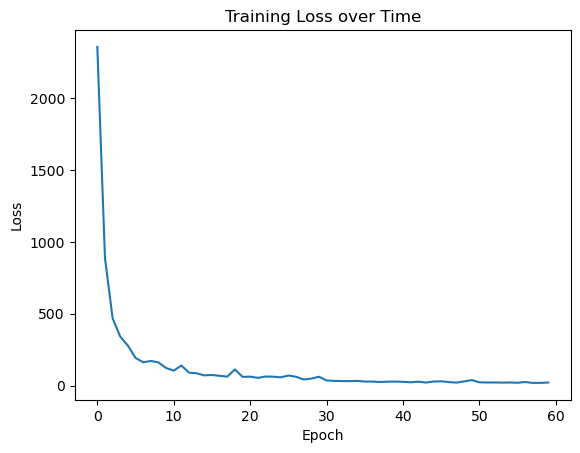

In [6]:
def create_sequences(X: torch.Tensor, y_angle: torch.Tensor, y_mass: torch.Tensor,
                    seq_length: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Create sequences for time series prediction with multiple targets
    """
    X_seq, y_angle_seq, y_mass_seq = [], [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_angle_seq.append(y_angle[i+seq_length])
        y_mass_seq.append(y_mass[i+seq_length])
    return torch.stack(X_seq), torch.stack(y_angle_seq), torch.stack(y_mass_seq)


def load_and_preprocess_data(directory: str, input_columns: list, 
                           angle_column: str, mass_column: str) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Load and preprocess data from CSV files with both angle and mass targets
    """
    data_list = []
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            filepath = os.path.join(directory, filename)
            data = pd.read_csv(filepath, sep=',', low_memory=False)
            data_list.append(data)

    combined_data = pd.concat(data_list, ignore_index=True)
    
    X = combined_data[input_columns].values
    y_angle = combined_data[angle_column].values
    y_angle = gaussian_filter(y_angle, sigma=7)
    y_mass = combined_data[mass_column].values
    
    return (torch.tensor(X, dtype=torch.float32),
            torch.tensor(y_angle, dtype=torch.float32),
            torch.tensor(y_mass, dtype=torch.float32))

if __name__ == "__main__":
    # Model parameters
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    input_size = 8
    hidden_size = 64
    sequence_length = 200
    batch_size = 40
    num_epochs = 60

    # Define input and target columns
    input_columns = ['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8']
    angle_column = 'kalman_angle_difference'
    mass_column = 'mass'  # Add your mass column name here

    # Load and preprocess data
    X_tensor, y_angle_tensor, y_mass_tensor = load_and_preprocess_data(
        './dataset', input_columns, angle_column, mass_column)
    
    # Create sequences
    X_seq, y_angle_seq, y_mass_seq = create_sequences(
        X_tensor, y_angle_tensor, y_mass_tensor, sequence_length)
    
    y_combined = torch.stack((y_angle_seq, y_mass_seq), dim=1)
    # Create dataset and dataloader
    dataset = TensorDataset(X_seq,y_combined)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize and train model
    model = ModifiedPiLSTM(input_size, hidden_size,I1, I2, m1, m2, l1, l2, g)
    train_losses = train_model(model, train_loader, num_epochs)

    # Plot training losses
    plt.plot(train_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Time')
    plt.show()

In [7]:
def evaluate_model(model: nn.Module, val_loader: DataLoader):
    """Evaluate the model on validation data"""
    device = next(model.parameters()).device  # Ensure compatibility with model's device
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_targets = []
    all_masses = []
    all_torques = []
    masses = torch.empty(0, 1)
    
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # Move data to GPU
            
            # Forward pass
            pred_kalman, pred_mass = model(batch_x)
            true_kalman = batch_y[:, 0].unsqueeze(1)
            true_mass = batch_y[:, 1].unsqueeze(1)
            
            # Calculate loss
            loss = model.combined_loss(pred_kalman, true_kalman, pred_mass, true_mass)
            total_loss += loss.item()
            masses = torch.cat((masses,pred_mass), dim = 0)
            pred_kalman = gaussian_filter(pred_kalman, sigma=10)
            pred_kalman = torch.from_numpy(pred_kalman)
            # Store predictions and targets for metrics
            all_preds.extend(pred_kalman.cpu().numpy().flatten())
            
            all_targets.extend(true_kalman.cpu().numpy().flatten())
            all_masses.extend(pred_mass.cpu().numpy().flatten())
            pred_torques = model.calc_torque(pred_kalman, masses, masses)
            all_torques.extend(pred_torques.cpu().numpy().flatten())
    
    # Rest of the code remains unchanged

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    all_masses = np.array(all_masses)
    all_torques = np.array(all_torques)
    
    # Create figure with subplots
    plt.figure(figsize=(15, 5))
    
    # Plot angles
    plt.subplot(1, 3, 1)
    plt.plot(all_preds, label='Predicted')
    plt.plot(all_targets, label='Actual')
    plt.xlabel('Time Step')
    plt.ylabel('Angle')
    plt.title('Predicted vs Actual Angles')
    plt.legend()
    
    # Plot masses
    plt.subplot(1, 3, 2)
    plt.plot(all_masses)
    plt.xlabel('Time Step')
    plt.ylabel('Mass')
    plt.title(f'Predicted Masses\nMean Mass: {np.mean(all_masses):.3f}')
    
    # Plot torques
    plt.subplot(1, 3, 3)
    plt.plot(all_torques)
    plt.xlabel('Time Step')
    plt.ylabel('Torque')
    plt.title('Predicted Torques')
    
    plt.tight_layout()
    plt.show()
    
    return total_loss / len(val_loader), all_preds, all_targets, all_masses, all_torques

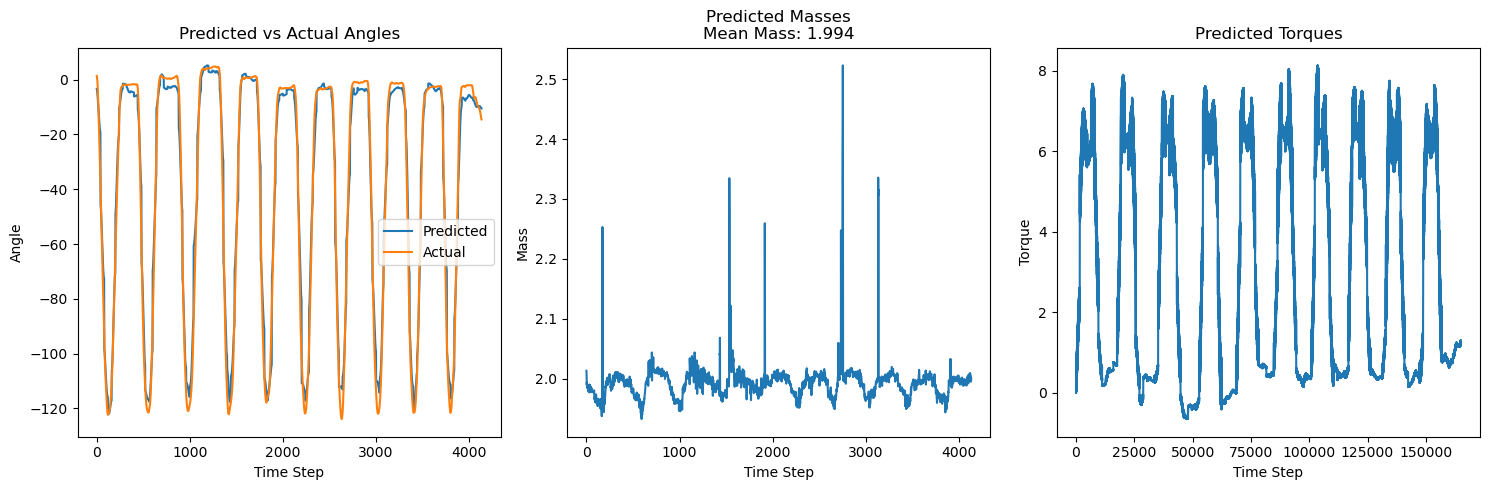

In [8]:
input_size = 8
hidden_size = 64
sequence_length = 200
batch_size = 40


    # Define input and target columns
input_columns = ['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8']
angle_column = 'kalman_angle_difference'
mass_column = 'mass'  # Add your mass column name here

# Load and preprocess data
X_val, y_val, _ = load_and_preprocess_data('./dataval', input_columns, angle_column, mass_column)
X_val_seq, y_val_seq,_ = create_sequences(X_val, y_val, _, sequence_length)
y_combined = torch.stack((y_val_seq,_), dim=1)
    # Create validation dataset and dataloader
val_dataset = TensorDataset(X_val_seq, y_combined)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

loss, all_preds, all_targets, all_masses, all_torques = evaluate_model(model, val_loader)

In [9]:
model_save_path = "trained_model.pt"
torch.save(model.state_dict(), model_save_path)
print(f"Trained model saved to {model_save_path}")

Trained model saved to trained_model.pt


In [10]:
model.load_state_dict(torch.load(model_save_path))
model.eval()  # Set the model to evaluation mode
print("Trained model loaded and ready for inference.")

Trained model loaded and ready for inference.


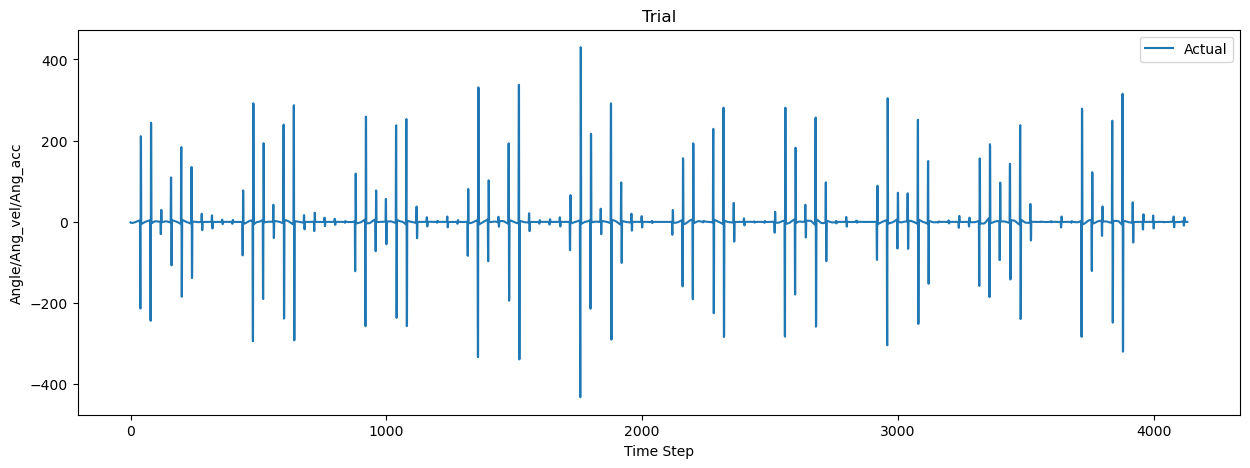

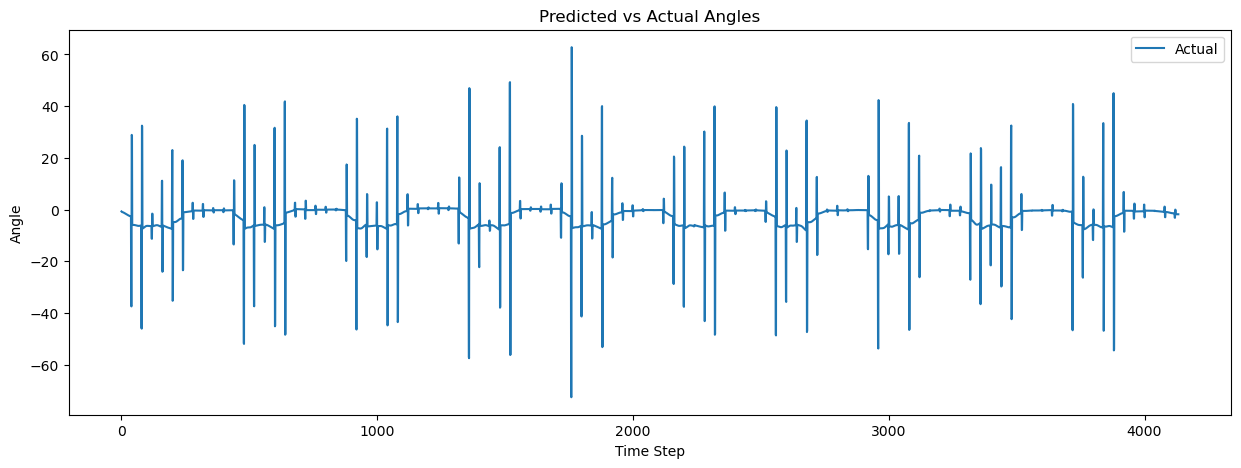

In [15]:
##### import numpy as np

#all_targets = gaussian_filter(all_targets, sigma=0)  # Adjust sigma for smoothing
def calculate_state_variables(theta, dt=0.02):
    """
    Calculate angular velocity (theta_dot) and angular acceleration (theta_ddot) using numerical gradients.
    """
    theta = np.squeeze(theta)  # Remove single-dimensional entries from shape
    theta_dot = np.gradient(theta, dt)  # Calculate first derivative
    theta_ddot = np.gradient(theta_dot, dt)  # Calculate second derivative
    plt.figure(figsize=(15, 5))
    plt.plot(theta_ddot, label='Actual')
    plt.xlabel('Time Step')
    plt.ylabel('Angle/Ang_vel/Ang_acc')
    plt.title('Trial')
    plt.legend()
    return theta[:, np.newaxis], theta_dot[:, np.newaxis], theta_ddot[:, np.newaxis]

def calc_torque(angle, mass, true_mass):
    theta_E, theta_dot_E, theta_ddot_E = calculate_state_variables(angle)
    theta_S = np.zeros_like(theta_E)
    theta_dot_S = np.zeros_like(theta_E)
    theta_ddot_S = np.zeros_like(theta_E)
    C21 = (m2 * l1 * l2 / 2 + mass * l1 * l2)  # Coefficient for shoulder acceleration
    C22 = (I2 + m2 * (l2**2) / 4 + mass * l2**2)  # Coefficient for elbow acceleration
    #C22 = 0
    C23 = (m2 * l1 * l2 / 2 + mass * l1 * l2)  # Coefficient for shoulder velocity squared term
    C24 = ((m2 * l2 / 2 + mass * l2) * g)  # Coefficient for gravitational term
    torque_E = (C22 * theta_ddot_E +C24 * np.sin(theta_E))
        
    return torque_E
all_preds1 = gaussian_filter(all_preds, sigma=10)  # Adjust sigma for smoothing
true_torque = calc_torque(np.deg2rad(all_preds),2,2)
plt.figure(figsize=(15, 5))
plt.plot(true_torque, label='Actual')
plt.xlabel('Time Step')
plt.ylabel('Angle')
plt.title('Predicted vs Actual Angles')
plt.legend()


### Without using any extra layer

In [16]:
input_size = 8
hidden_size = 64
sequence_length = 200
batch_size = 40
    
    # Define input and target columns
input_columns = ['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8']
angle_column = 'kalman_angle_difference'
mass_column = 'mass'  # Add your mass column name here

# Load and preprocess data
X_val, y_val, _ = load_and_preprocess_data('/kaggle/input/data-val', input_columns, angle_column, mass_column)
X_val_seq, y_val_seq,_ = create_sequences(X_val, y_val, _, sequence_length)
y_combined = torch.stack((y_val_seq,_), dim=1)
    # Create validation dataset and dataloader
val_dataset = TensorDataset(X_val_seq, y_combined)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

evaluate_model(model, val_loader)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/data-val'

In [ ]:


# Apply Gaussian filter
smoothed_data = gaussian_filter(all_targets, sigma=15)  # Adjust sigma for smoothing
plt.figure(figsize=(15, 5))
plt.plot(smoothed_data, label='Actual')
plt.plot(all_targets, label='Actual')
plt.xlabel('Time Step')
plt.ylabel('Angle')
plt.title('Predicted vs Actual Angles')
plt.legend()

one, two, three = calculate_state_variables(smoothed_data, dt=0.02)
plt.figure(figsize=(15, 5))
plt.plot(two, label='Actual')
plt.xlabel('Time Step')
plt.ylabel('Angle')
plt.title('Predicted vs Actual Angles')
plt.legend()
